In [1]:
import os
import json
import numpy as np
import pandas as pd
import random
import datetime

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as Optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
%load_ext tensorboard

from PIL import Image, ImageEnhance
import cv2

%matplotlib notebook
import matplotlib.animation
import matplotlib.pyplot as plt

tf.__version__

'2.2.0'

In [2]:
import conf

data_dir = "data/robo_racing_track_cam_full2"

batch_size = conf.training_batch_size
epochs = conf.training_epochs
img_height = conf.image_height
img_width = conf.image_width
img_channels = conf.image_depth

crop_top = conf.crop_top

class_nb = (len(conf.speed_idx), len(conf.angle_idx))

val_split = conf.val_split

model_name = "models/model_robo_cam_full2_2.h5"

In [3]:
raw_Y = []
for f in os.listdir(data_dir):
    if f.endswith(".json") and "meta" not in f:
        with open(os.path.join(data_dir, f)) as fd:
            data_id = f.split("_")[1].split(".")[0]
            try:
                data = json.load(fd)
                raw_Y.append({"id": int(data_id), "throttle": data["user/throttle"], "angle": data["user/angle"]})
            except:
                print(data_id)
                break
raw_Y = sorted(raw_Y, key=lambda item: item["id"])
len(raw_Y)

37705

In [4]:
def plot_values(Y):
    fig, ax = plt.subplots(2,1)
    ax[0].plot([Y[i]["throttle"] for i in range(len(Y))])
    ax[1].plot([Y[i]["angle"] for i in range(len(Y))])

<IPython.core.display.Javascript object>


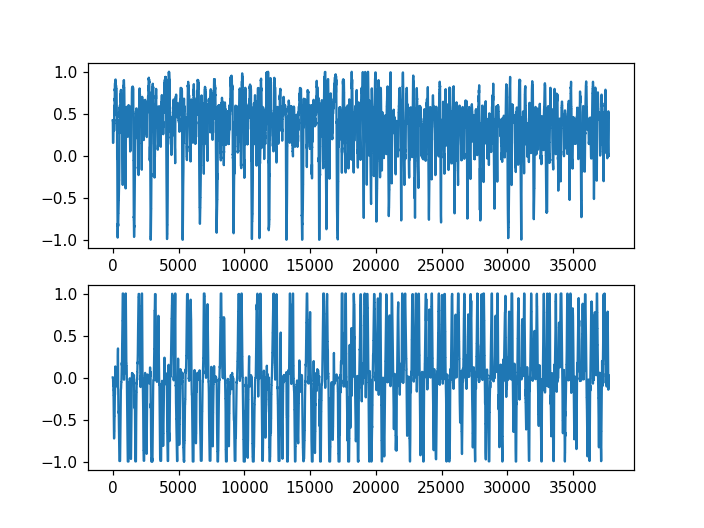

In [5]:
plot_values(raw_Y)

In [6]:
Y = []
for n, i in enumerate([x["id"] for x in raw_Y]):
    Y.append({"id": i})
    for i, lim in enumerate(conf.speed_lims):    
        if (raw_Y[n]["throttle"] < lim):
            Y[n]["throttle"] = i
            break
        Y[n]["throttle"] = len(conf.speed_idx) - 1
        
    for i, lim in enumerate(conf.angle_lims):    
        if (raw_Y[n]["angle"] < lim):
            Y[n]["angle"] = i
            break
        Y[n]["angle"] = len(conf.angle_idx) - 1

<IPython.core.display.Javascript object>


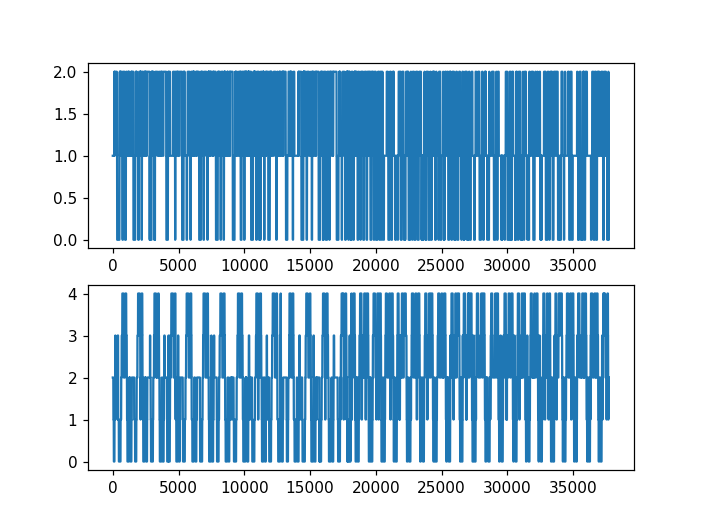

In [7]:
plot_values(Y)

<IPython.core.display.Javascript object>


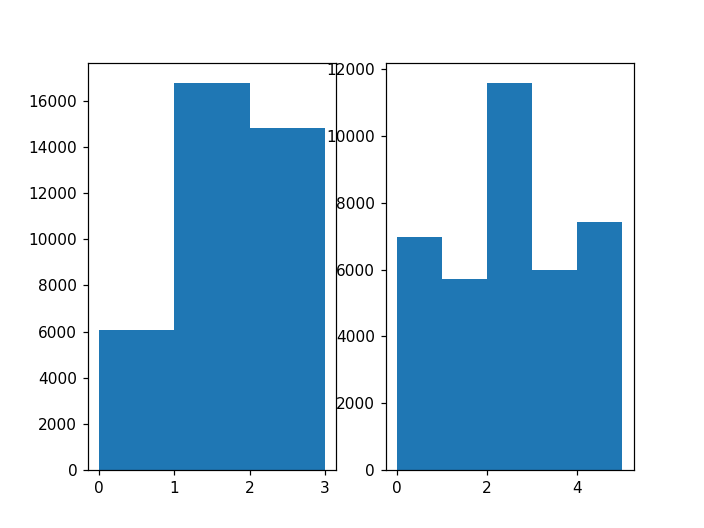

(array([ 6978.,  5716., 11600.,  5993.,  7418.]),
 array([0., 1., 2., 3., 4., 5.]),
 <a list of 5 Patch objects>)

In [8]:
sum_sp = []
sum_dir = []

for v in Y:
    sum_sp.append(v["throttle"])
    sum_dir.append(v["angle"])

fig, ax = plt.subplots(1, 2)
ax[0].hist(sum_sp, range=(0, class_nb[0]), bins=class_nb[0])
ax[1].hist(sum_dir, range=(0, class_nb[1]), bins=class_nb[1])

In [9]:
class DataGenerator(Sequence):
    def __init__(self, data, data_path, class_nb, batch_size=32, val=False, val_split=0.2, shuffle=False, mirror=False, noise=None, contrast=False, light=False, thresh=False):
        super().__init__()

        if val:
            self.data = [data[i] for i in range(int((1 - val_split) * len(data)), len(data))]
        else:
            self.data = [data[i] for i in range(0, int((1 - val_split) * len(data)))]
            
        self.val = val
        self.class_nb = class_nb
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.mirror = mirror
        self.noise = noise
        self.contrast = contrast
        self.light = light
        self.thresh = thresh
        self.data_path = data_path
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def flip_img(self, X, y_dir):
        if np.random.randint(2):
            X = tf.image.flip_left_right(X)
            y_dir = np.flip(y_dir)
        return X, y_dir
    
    def gaussian_noise(self, img, prob):
        noise = np.random.normal(1, prob ** 0.5, img.shape)
        img *= noise
        return img
    
    def add_rects(self, img):
        w = int(np.random.uniform(0.2, 0.4) * img_width)
        h = int(np.random.uniform(0.2, 0.4) * img_height)
        x = np.random.randint(img_width-w)
        y = np.random.randint(img_height-h)
        box = np.array([np.random.randint(0, 100, (h,w,1))])
        img[y:y+h, x:x+w] = box
        return img
        
    def add_noise(self, img):
        p = np.random.rand(1)
        if p < 0.3:
            return self.gaussian_noise(img, 0.02)
        elif p < 0.6:
            if np.random.rand(1) < 0.5:
                img = self.add_rects(img)
            return self.add_rects(img)
        return img
    
    def random_light(self, img):
        rnd = np.random.uniform(0.5, 1.2)
        img *= rnd
        return img
    
    def random_contrast(self, img):
        contrast = ImageEnhance.Contrast(img)
        img = contrast.enhance(1.5)#np.random.uniform(0.5, 1.5))
        return img
    
    def binary_thresh(self, img):
        #p = np.random.rand(1)
        #ret = False
        #if p < 0.3:
        m = np.max(img) - 15
        #if img.shape[-1] == 3:
        #    img[...,1] = img[...,0]
        #    img[...,2] = img[...,0]
        #img[img < m] = 0    # Black
        img[img >= m] = 255 # White
        ret = True
        return ret, img
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size, img_height - crop_top, img_width, img_channels), dtype=np.float32)
        y_speed = np.empty((self.batch_size, class_nb[0]), dtype=np.float32)
        y_dir = np.empty((self.batch_size, class_nb[1]), dtype=np.float32)
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        for i, idx in enumerate(indexes):

            if conf.image_depth == 1:
                img = Image.open(os.path.join(self.data_path, str(self.data[idx]["id"]) + "_cam-image_array_.jpg")).convert("L")
            else:
                img = Image.open(os.path.join(self.data_path, str(self.data[idx]["id"]) + "_cam-image_array_.jpg"))
                #img = cv2.imread(os.path.join(self.data_path, str(self.data[idx]["id"]) + "_cam-image_array_.jpg"))
            
            if self.contrast:
                img = self.random_contrast(img)
            
            if conf.image_depth == 1:
                X[i,] = np.expand_dims(np.array(img), 2)
            else:
                X[i,] = np.array(img)
                
            y_speed[i,] = to_categorical(self.data[idx]["throttle"], num_classes=class_nb[0])
            y_dir[i,] = to_categorical(self.data[idx]["angle"], num_classes=class_nb[1])
            
            """if self.val == False:
                m = 130
                X[i,][X[i,] < m] = np.mean(X[i,])"""
            
            ret = False
            if self.noise:
                X[i,] = self.add_noise(X[i,])
            if self.thresh:
                ret, X[i,] = self.binary_thresh(X[i,])
            if ret == False and self.light:
                X[i,] = self.random_light(X[i,])
            if self.mirror and self.data[idx]["angle"] != len(conf.angle_lims) // 2: 
                X[i,], y_dir[i,] = self.flip_img(X[i,], y_dir[i,])
            

            
            X[i,] = np.clip(X[i,], 0, 255)
            X[i,] = np.array(X[i,]) / 255.0
            
            
            
        return X, [y_speed, y_dir]


In [10]:
random.shuffle(Y)

train_batches = DataGenerator(Y, data_dir, class_nb, batch_size=batch_size, val=False , val_split=0.2, shuffle=True, mirror=True, noise=True, light=True, contrast=True, thresh=False)
val_batches = DataGenerator(Y, data_dir, class_nb, batch_size=batch_size, val=True, val_split=0.2, shuffle=True, mirror=True, noise=True, light=True, contrast=True, thresh=False)

942 235


<IPython.core.display.Javascript object>


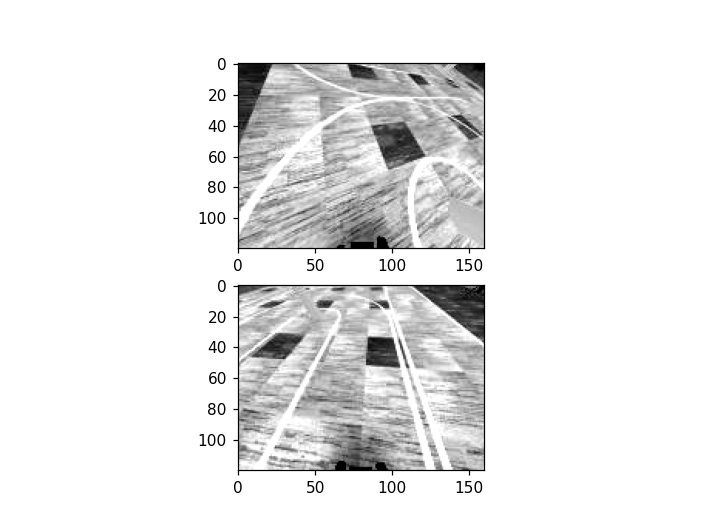

[1. 0. 0.] [0. 0. 0. 0. 1.] [0. 1. 0.] [0. 0. 1. 0. 0.]


(120, 160, 1)

In [11]:
batch = 0
idx = 0

print(len(train_batches), len(val_batches))

train_test = train_batches[batch]
val_test = val_batches[batch]

fig, ax = plt.subplots(2,1)
ax[0].imshow(np.squeeze(train_test[0][idx]), cmap="gray")
ax[1].imshow(np.squeeze(val_test[0][idx]), cmap="gray")
fig.show()
print(train_test[1][0][idx], train_test[1][1][idx], val_test[1][0][idx], val_test[1][1][idx])

train_test[0][idx].shape

<IPython.core.display.Javascript object>


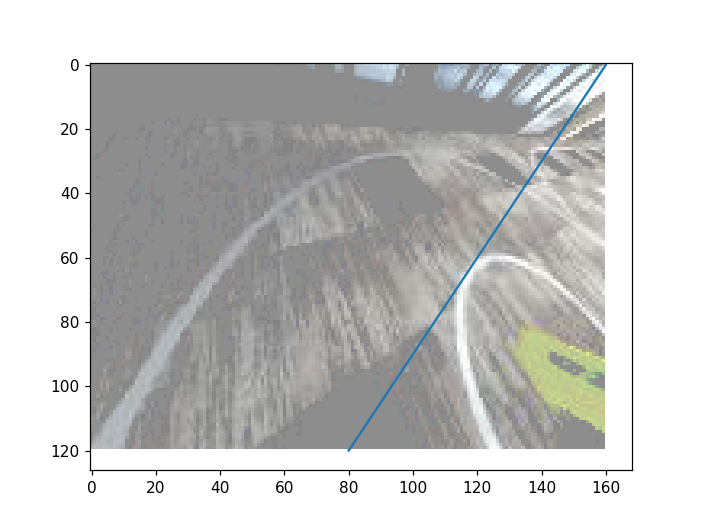

In [20]:
nb_frames = 2000

fig, ax = plt.subplots()
def animate(t):
    plt.cla()
    batch = train_batches[t // 128]
    img = batch[0][t % 128]
    label = np.argmax(batch[1][1][t % 128])
    plt.imshow(np.squeeze(img), cmap="gray")
    plt.plot((img_width // 2, label * img_width  // (len(conf.angle_idx) - 1)), (img_height, 0))
    plt.pause(0.1)
matplotlib.animation.FuncAnimation(fig, animate, frames=nb_frames)

In [35]:
'''
Model from PatateV2
'''

K.clear_session()
############################################################# 

img_in = Input(shape=(img_height - crop_top, img_width, img_channels), name='img_in')
x = img_in

x = Convolution2D(8, kernel_size=5, strides=2, activation="relu")(x)
x = Dropout(0.6)(x)
x = Convolution2D(16, kernel_size=5, strides=2, activation="relu")(x)
x = Dropout(0.3)(x)
x = Convolution2D(32, kernel_size=5, strides=2, activation="relu")(x)
#x = Dropout(0.2)(x)
#x = Convolution2D(64, kernel_size=3, strides=1, activation="relu")(x)
#x = Convolution2D(64, kernel_size=3, strides=1, activation="relu")(x)

x = Flatten()(x)

#x = Dense(1000, activation="relu")(x)
#x = Dropout(0.2)(x)
#x = Dense(200, activation="relu")(x)
#x = Dropout(0.2)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(10, activation="relu")(x)

# Multitask Output
out_speed = Dense(class_nb[0], activation='softmax')(x)
out_dir = Dense(class_nb[1], activation='softmax')(x)

#opti = Optimizers.Adadelta(learning_rate=1.0)

# Compile Model
model = Model(inputs=[img_in], outputs=[out_speed, out_dir])
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             [(None, 120, 160, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 58, 78, 8)    208         img_in[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 58, 78, 8)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 27, 37, 16)   3216        dropout[0][0]                    
______________________________________________________________________________________________

In [12]:
model = load_model("models/model_robo_cam_slow_best.h5")
"""#model_name = "models/model_camv2_full2_2.h5"
for layer in model.layers:
    print(layer.output)"""

'#model_name = "models/model_camv2_full2_2.h5"\nfor layer in model.layers:\n    print(layer.output)'

In [13]:
#save best model if model improved
best_checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
!rm -rf logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [15]:
%tensorboard --logdir logs --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 19572), started 0:01:35 ago. (Use '!kill 19572' to kill it.)

In [16]:
h = model.fit(train_batches, validation_data=val_batches, batch_size=batch_size, epochs=20, verbose=1, callbacks=[best_checkpoint, tensorboard_callback])

Epoch 1/20
942/942 [==============================] - ETA: 0s - loss: 0.7204 - dense_2_loss: 0.4226 - dense_3_loss: 0.2978 - dense_2_accuracy: 0.8310 - dense_3_accuracy: 0.8915
Epoch 00001: val_loss improved from inf to 0.47821, saving model to models/model_robo_cam_full2_2.h5
942/942 [==============================] - 94s 100ms/step - loss: 0.7204 - dense_2_loss: 0.4226 - dense_3_loss: 0.2978 - dense_2_accuracy: 0.8310 - dense_3_accuracy: 0.8915 - val_loss: 0.4782 - val_dense_2_loss: 0.2762 - val_dense_3_loss: 0.2020 - val_dense_2_accuracy: 0.8948 - val_dense_3_accuracy: 0.9243
Epoch 2/20
942/942 [==============================] - ETA: 0s - loss: 0.4827 - dense_2_loss: 0.2790 - dense_3_loss: 0.2036 - dense_2_accuracy: 0.8944 - dense_3_accuracy: 0.9242- ETA: 4s - loss: 0.4844 - dense_2_loss: 0.2795 - dense_ - ETA: 0s - loss: 0.4831 - dense_2_loss: 0.2793 - dense_3_loss: 0.2038 - dense_2_accuracy: 0.8944 - dense_3_accuracy: 0.
Epoch 00002: val_loss improved from 0.47821 to 0.40406, savi

942/942 [==============================] - ETA: 0s - loss: 0.2077 - dense_2_loss: 0.1163 - dense_3_loss: 0.0914 - dense_2_accuracy: 0.9601 - dense_3_accuracy: 0.9700- ETA: 5s - loss: 0.2050 - dens
Epoch 00011: val_loss did not improve from 0.28423
942/942 [==============================] - 70s 75ms/step - loss: 0.2077 - dense_2_loss: 0.1163 - dense_3_loss: 0.0914 - dense_2_accuracy: 0.9601 - dense_3_accuracy: 0.9700 - val_loss: 0.2993 - val_dense_2_loss: 0.1622 - val_dense_3_loss: 0.1372 - val_dense_2_accuracy: 0.9517 - val_dense_3_accuracy: 0.9569
Epoch 12/20
942/942 [==============================] - ETA: 0s - loss: 0.2045 - dense_2_loss: 0.1150 - dense_3_loss: 0.0896 - dense_2_accuracy: 0.9605 - dense_3_accuracy: 0.9709
Epoch 00012: val_loss did not improve from 0.28423
942/942 [==============================] - 70s 74ms/step - loss: 0.2045 - dense_2_loss: 0.1150 - dense_3_loss: 0.0896 - dense_2_accuracy: 0.9605 - dense_3_accuracy: 0.9709 - val_loss: 0.3000 - val_dense_2_loss: 0.166

<IPython.core.display.Javascript object>


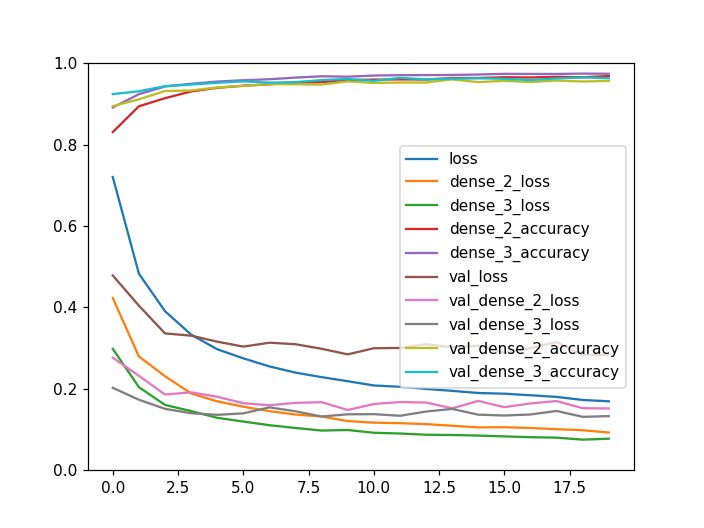

In [17]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [ ]:
model.save("models/model_init_RL.h5")

In [42]:
model = load_model(model_name)

<IPython.core.display.Javascript object>


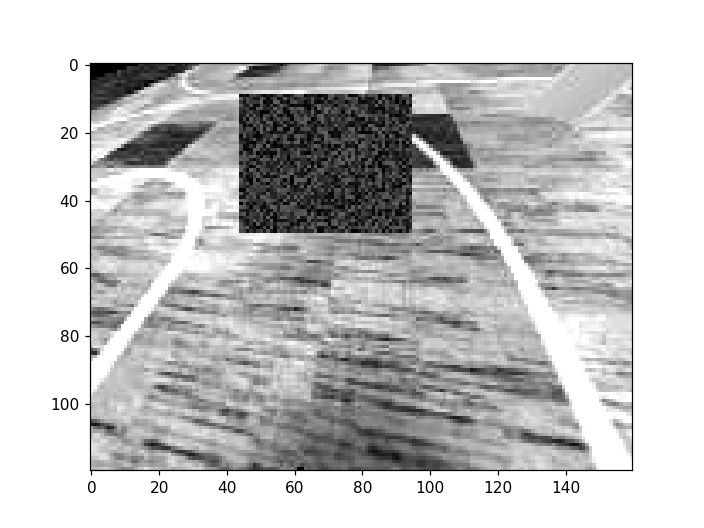

speed :  1
dir :  1


In [41]:
batch = 0
idx = 0

img = val_batches[batch][0][idx]

fig = plt.figure()
if img.shape[-1] == 1:
    plt.imshow(np.squeeze(img), cmap="gray")
else:
    plt.imshow(img)
fig.show()
pred = model.predict(np.array([img]))
print("speed : ", np.argmax(pred[0]))
print("dir : ", np.argmax(pred[1]))

(1, 58, 78, 8)


<IPython.core.display.Javascript object>


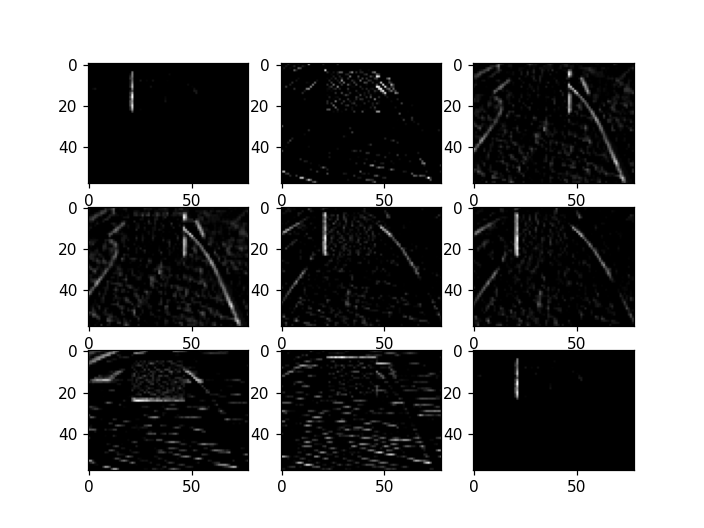

(1, 27, 37, 16)


<IPython.core.display.Javascript object>


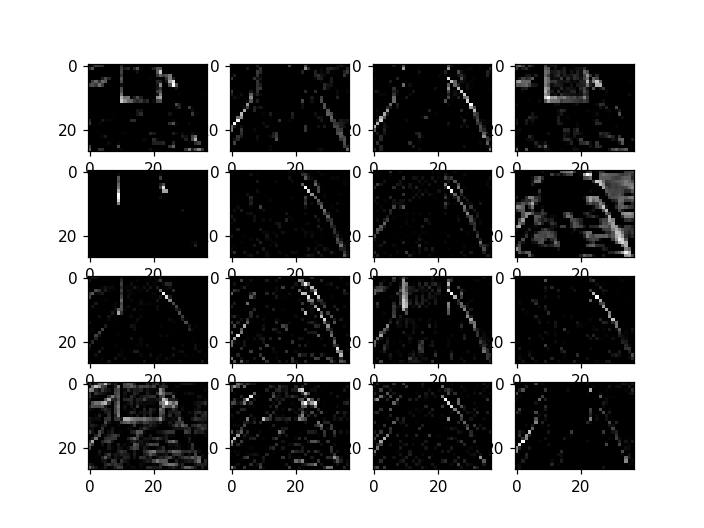

(1, 12, 17, 32)


<IPython.core.display.Javascript object>


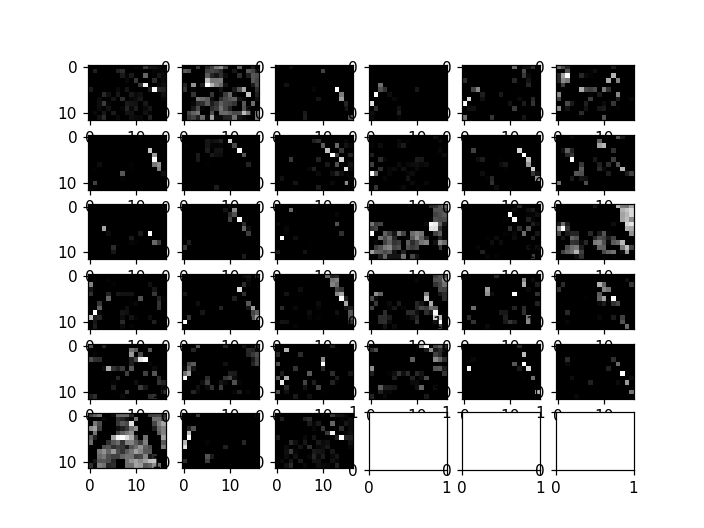

In [42]:
for layer_idx in range(len(model.layers)):
    if isinstance(model.layers[layer_idx], tf.keras.layers.Conv2D):
        layer = Model(inputs=model.inputs, outputs=model.layers[layer_idx].output)
        if conf.image_depth == 1:
            np_img = np.expand_dims(np.array(img)[:,:,0], (0,3))
        else:
            np_img = np.expand_dims(np.array(img), 0)
        feature_maps = layer.predict(np_img)
        out_shape = feature_maps.shape
        print(out_shape)

        square = np.sqrt(out_shape[-1])
        if square - int(square) > 1e-16 :
            square = int(square) + 1
        else:
            square = int(square)

        fig, axes = plt.subplots(square, square)
        idx = 0
        for i in range(square):
            for j in range(square):
                # plot filter channel in grayscale
                try:
                    axes[i, j].imshow(feature_maps[0, :, :, idx-1], cmap='gray')
                except:
                    pass
                idx += 1
        # show the figure
        fig.show()

<IPython.core.display.Javascript object>


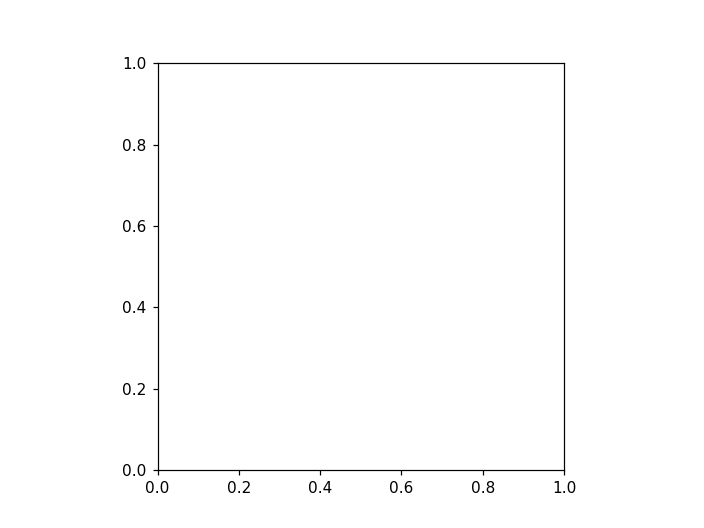

In [43]:
nb_frames = 200

fig, ax = plt.subplots()
def animate(t):
    plt.cla()
    batch = val_batches[t // 128]
    img = batch[0][t % 128]
    label = np.argmax(batch[1][1][t % 128])
    pred = np.argmax(model.predict(np.expand_dims(img, 0))[1])
    if img.shape[-1] == 1:
        plt.imshow(np.squeeze(img), cmap="gray")
    else:
        plt.imshow(img)
    plt.plot((img_width // 2, label * img_width  // (len(conf.angle_idx) - 1)), (img_height, 0), color="blue")
    plt.plot((img_width // 2, pred * img_width  // (len(conf.angle_idx) - 1)), (img_height, 0), color="red")
    plt.pause(0.01)
    
matplotlib.animation.FuncAnimation(fig, animate, frames=nb_frames)